# Model Optimization

In [1]:
# get the data 
import ml_utils as mu

with mu.HiddenPrints():
    X, y , Xh, yh, Xv, yv = mu.get_training_holdout_validation_data()

models = mu.get_baseline_models()
models = {model['name'] : model['model'] for model in models}

In [24]:
y.value_counts()

1    319
0    192
3     44
2     41
Name: GroupID, dtype: int64

In [25]:
from datetime import datetime

import numpy as np
import pandas as pd
from IPython.display import display

from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

RESULTS_FILE = 'grid_search_results.csv'

def do_grid_search(mod_clf, mod_name, params, cv=5, scoring='accuracy'):
    clf = Pipeline([
            ('standardization', StandardScaler()),
            ('oversampler', RandomOverSampler()),
            ('classifier', mod_clf)
    ])
    with mu.Timer('Hyperparameter Grid Search for %s' %mod_name):
        best = mu.grid_search_optimization(clf, params, X, y, Xh, yh, Xv, yv, cv=cv, scoring=scoring)
        accuracy = {
            "model" : mod_name, 
            "mean_cv_acc" : best.best_estimator_.score(X,y),
            "holdout_acc" : best.best_estimator_.score(Xh,yh),
            "validation_acc" : best.best_estimator_.score(Xv,yv),
            "date_modified" : datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "best_params" : str(best.best_params_),
            "cv": cv
        }
    return accuracy

def getData():
    try:
        return pd.read_csv(RESULTS_FILE, index_col=0)
    except:
        pass
    return pd.DataFrame()

def addData(new_data, save=True):
    df = getData()
    df = df.append(new_data, ignore_index=True)
    if save:
        saveData(df)
    return df
    
def saveData(df):
    df[['model', 'mean_cv_acc', 'holdout_acc', 'validation_acc', 'cv', 'best_params', 'date_modified']].to_csv(RESULTS_FILE)
    
def showData(df, name):
    if name:
        display(df.loc[df.model == name].set_index('model')[['mean_cv_acc', 'holdout_acc', 'validation_acc', 'date_modified']])
    else:
        display(df.set_index('model')[['mean_cv_acc', 'holdout_acc', 'validation_acc', 'date_modified']])
            
def delete_row(index = None, last=False):
    if not (index or last):
        return
    df = getData()
    if last:
        df = df.drop(df.index[len(df)-1])
    if index:
        df = df.drop(index)
    saveData(df)
    return df

In [74]:
# SVC Linear
mod_name ="svc_lin"
mod_clf = models[mod_name]
params = { "classifier__C": np.logspace(0, 0.75, 60)}

accuracy = do_grid_search(mod_clf, mod_name, params, 10)

df = addData(accuracy)
showData(df, mod_name)

[2018-07-11 19:54:30.950188] Starting Hyperparameter Grid Search for svc_lin
# Tuning hyper-parameters for accuracy

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   22.9s finished


Best parameters set found on development set:

{'classifier__C': 4.8578117159706746}

Grid scores on development set:

0.822 (+/-0.107) for {'classifier__C': 1.0}
0.819 (+/-0.107) for {'classifier__C': 1.0297027305689221}
0.822 (+/-0.117) for {'classifier__C': 1.0602877133410944}
0.814 (+/-0.102) for {'classifier__C': 1.0917811536160034}
0.815 (+/-0.121) for {'classifier__C': 1.1242100350620865}
0.805 (+/-0.109) for {'classifier__C': 1.1576021428364143}
0.815 (+/-0.100) for {'classifier__C': 1.1919860873910912}
0.817 (+/-0.121) for {'classifier__C': 1.2273913289867726}
0.826 (+/-0.101) for {'classifier__C': 1.2638482029342979}
0.819 (+/-0.130) for {'classifier__C': 1.301387945586072}
0.822 (+/-0.122) for {'classifier__C': 1.3400427210994581}
0.819 (+/-0.114) for {'classifier__C': 1.3798456489951207}
0.815 (+/-0.115) for {'classifier__C': 1.4208308325339223}
0.812 (+/-0.124) for {'classifier__C': 1.4630333879366948}
0.809 (+/-0.122) for {'classifier__C': 1.5064894744719157}
0.817 (+/-0.

,mean_cv_acc,holdout_acc,validation_acc,date_modified
model,,,,
svc_lin,0.953020,0.665625,0.695312,2018-07-11 12:09:37
svc_lin,0.936242,0.662500,0.742188,2018-07-11 19:54:11
svc_lin,0.949664,0.668750,0.687500,2018-07-11 19:54:18
svc_lin,0.946309,0.659375,0.687500,2018-07-11 19:54:27
svc_lin,0.944631,0.678125,0.679688,2018-07-11 19:54:54


In [77]:
# Logorithmic Regression
mod_name ="log"
mod_clf = models[mod_name]

params = {
    "classifier__penalty": ['l1', 'l2'],
    "classifier__C": np.logspace(0, 6, 30)
}

accuracy = do_grid_search(mod_clf, mod_name, params, 10)

df = addData(accuracy)
showData(df, mod_name)

[2018-07-11 19:59:07.255509] Starting Hyperparameter Grid Search for log
# Tuning hyper-parameters for accuracy

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   22.5s finished


Best parameters set found on development set:

{'classifier__C': 28.072162039411772, 'classifier__penalty': 'l2'}

Grid scores on development set:

0.789 (+/-0.134) for {'classifier__C': 1.0, 'classifier__penalty': 'l1'}
0.768 (+/-0.127) for {'classifier__C': 1.0, 'classifier__penalty': 'l2'}
0.794 (+/-0.124) for {'classifier__C': 1.6102620275609394, 'classifier__penalty': 'l1'}
0.780 (+/-0.114) for {'classifier__C': 1.6102620275609394, 'classifier__penalty': 'l2'}
0.784 (+/-0.134) for {'classifier__C': 2.5929437974046672, 'classifier__penalty': 'l1'}
0.780 (+/-0.102) for {'classifier__C': 2.5929437974046672, 'classifier__penalty': 'l2'}
0.787 (+/-0.125) for {'classifier__C': 4.1753189365604015, 'classifier__penalty': 'l1'}
0.780 (+/-0.112) for {'classifier__C': 4.1753189365604015, 'classifier__penalty': 'l2'}
0.787 (+/-0.138) for {'classifier__C': 6.7233575364993365, 'classifier__penalty': 'l1'}
0.780 (+/-0.136) for {'classifier__C': 6.7233575364993365, 'classifier__penalty': 'l2'}
0.

,mean_cv_acc,holdout_acc,validation_acc,date_modified
model,,,,
log,0.845638,0.746875,0.640625,2018-07-11 19:59:01
log,0.848993,0.718750,0.625000,2018-07-11 19:59:30


In [6]:
# SVC (RBF kernel) Regression
mod_name ="svc_rbf"
mod_clf = models[mod_name]

params = {
    "classifier__C": np.logspace(-5,15,10),
    "classifier__gamma": np.logspace(-15, 3, 10)
}

accuracy = do_grid_search(mod_clf, mod_name, params)

df = addData(accuracy)
showData(df, mod_name)

[2018-07-11 20:10:16.435748] Starting Hyperparameter Grid Search for svc_rbf
# Tuning hyper-parameters for accuracy

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   57.4s finished


Best parameters set found on development set:

{'classifier__C': 46.415888336127821, 'classifier__gamma': 0.001}

Grid scores on development set:

0.654 (+/-0.102) for {'classifier__C': 1.0000000000000001e-05, 'classifier__gamma': 1.0000000000000001e-15}
0.671 (+/-0.021) for {'classifier__C': 1.0000000000000001e-05, 'classifier__gamma': 1e-13}
0.666 (+/-0.074) for {'classifier__C': 1.0000000000000001e-05, 'classifier__gamma': 9.9999999999999994e-12}
0.599 (+/-0.196) for {'classifier__C': 1.0000000000000001e-05, 'classifier__gamma': 1.0000000000000001e-09}
0.537 (+/-0.190) for {'classifier__C': 1.0000000000000001e-05, 'classifier__gamma': 9.9999999999999995e-08}
0.510 (+/-0.063) for {'classifier__C': 1.0000000000000001e-05, 'classifier__gamma': 1.0000000000000001e-05}
0.592 (+/-0.077) for {'classifier__C': 1.0000000000000001e-05, 'classifier__gamma': 0.001}
0.626 (+/-0.186) for {'classifier__C': 1.0000000000000001e-05, 'classifier__gamma': 0.10000000000000001}
0.535 (+/-0.007) for {'cla

,mean_cv_acc,holdout_acc,validation_acc,date_modified
model,,,,
svc_rbf,0.931208,0.76250,0.687500,2018-07-11 20:08:55
svc_rbf,0.937919,0.75625,0.703125,2018-07-11 20:11:14


In [11]:
# KNN
mod_name ="knn"
mod_clf = models[mod_name]

params = {
    "classifier__weights": ['uniform', 'distance'],
    "classifier__n_neighbors": range(50, 150, 10),
    "classifier__p": range(1,10),
}

accuracy = do_grid_search(mod_clf, mod_name, params)

df = addData(accuracy)
showData(df, mod_name)

[2018-07-11 20:52:32.760591] Starting Hyperparameter Grid Search for knn
# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  1.7min finished


Best parameters set found on development set:

{'classifier__n_neighbors': 110, 'classifier__p': 1, 'classifier__weights': 'distance'}

Grid scores on development set:

0.718 (+/-0.047) for {'classifier__n_neighbors': 50, 'classifier__p': 1, 'classifier__weights': 'uniform'}
0.733 (+/-0.057) for {'classifier__n_neighbors': 50, 'classifier__p': 1, 'classifier__weights': 'distance'}
0.673 (+/-0.042) for {'classifier__n_neighbors': 50, 'classifier__p': 2, 'classifier__weights': 'uniform'}
0.688 (+/-0.087) for {'classifier__n_neighbors': 50, 'classifier__p': 2, 'classifier__weights': 'distance'}
0.666 (+/-0.040) for {'classifier__n_neighbors': 50, 'classifier__p': 3, 'classifier__weights': 'uniform'}
0.654 (+/-0.054) for {'classifier__n_neighbors': 50, 'classifier__p': 3, 'classifier__weights': 'distance'}
0.628 (+/-0.039) for {'classifier__n_neighbors': 50, 'classifier__p': 4, 'classifier__weights': 'uniform'}
0.639 (+/-0.098) for {'classifier__n_neighbors': 50, 'classifier__p': 4, 'class

,mean_cv_acc,holdout_acc,validation_acc,date_modified
model,,,,
knn,1.0,0.5875,0.656250,2018-07-11 20:46:44
knn,1.0,0.6375,0.601562,2018-07-11 20:54:16


In [3]:
# Random Forest
mod_name ="rand_for"
mod_clf = models[mod_name]

params = {
    "classifier__n_estimators": range(25,200, 25),
#     "classifier__max_features": range(1, 38, 2),
#     "classifier__max_depth": range(1, 21, 2),
    "classifier__min_samples_split": range(2, 20, 2),
    "classifier__min_samples_leaf": range(1, 25, 3),
}

accuracy = do_grid_search(mod_clf, mod_name, params)

df = addData(accuracy)
showData(df, mod_name)

[2018-07-11 21:56:06.734119] Starting Hyperparameter Grid Search for rand_for
# Tuning hyper-parameters for accuracy

Fitting 5 folds for each of 504 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed:  2.0min finished


Best parameters set found on development set:

{'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 8, 'classifier__n_estimators': 50}

Grid scores on development set:

0.856 (+/-0.053) for {'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 25}
0.857 (+/-0.046) for {'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
0.871 (+/-0.051) for {'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 75}
0.866 (+/-0.058) for {'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
0.872 (+/-0.067) for {'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 125}
0.874 (+/-0.062) for {'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 150}
0.869 (+/-0.058) for {'classifier__min_samples_leaf': 1, 'clas

,mean_cv_acc,holdout_acc,validation_acc,date_modified
model,,,,
rand_for,0.926174,0.7,0.710938,2018-07-11 21:58:08


In [23]:
# ANN
mod_name ="ann"
mod_clf = models[mod_name]

params = {
    "classifier__hidden_layer_sizes": [(100,100),(100,100,100),(100,100,100,100),(100,100,100,100,100)],
    "classifier__activation": ['identity', 'logistic', 'tanh', 'relu'],
    "classifier__solver": ['lbfgs', 'sgd', 'adam'],
    "classifier__alpha":[0.1*x for x in range(1,20)],
}

accuracy = do_grid_search(mod_clf, mod_name, params)

df = addData(accuracy)
showData(df, mod_name)

Before with
[2018-07-12 01:04:16.964966] Starting Hyperparameter Grid Search for ann
Inside with
# Tuning hyper-parameters for accuracy

Fitting 5 folds for each of 912 candidates, totalling 4560 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 33.1min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 53.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 73.2min
[Parallel(n_jobs=-1)]: Done 4560 out of 4560 | elapsed: 84.1min finished


Best parameters set found on development set:

{'classifier__activation': 'relu', 'classifier__alpha': 0.30000000000000004, 'classifier__hidden_layer_sizes': (100, 100), 'classifier__solver': 'lbfgs'}

Grid scores on development set:

0.795 (+/-0.097) for {'classifier__activation': 'identity', 'classifier__alpha': 0.1, 'classifier__hidden_layer_sizes': (100, 100), 'classifier__solver': 'lbfgs'}
0.814 (+/-0.068) for {'classifier__activation': 'identity', 'classifier__alpha': 0.1, 'classifier__hidden_layer_sizes': (100, 100), 'classifier__solver': 'sgd'}
0.826 (+/-0.084) for {'classifier__activation': 'identity', 'classifier__alpha': 0.1, 'classifier__hidden_layer_sizes': (100, 100), 'classifier__solver': 'adam'}
0.802 (+/-0.088) for {'classifier__activation': 'identity', 'classifier__alpha': 0.1, 'classifier__hidden_layer_sizes': (100, 100, 100), 'classifier__solver': 'lbfgs'}
0.820 (+/-0.086) for {'classifier__activation': 'identity', 'classifier__alpha': 0.1, 'classifier__hidden_layer

,mean_cv_acc,holdout_acc,validation_acc,date_modified
model,,,,
ann,1.0,0.746875,0.710938,2018-07-12 02:28:23


In [24]:
# Naive Bayes
mod_name ="gnb"
mod_clf = models[mod_name]

params = {
    "classifier__priors": [None]
}

accuracy = do_grid_search(mod_clf, mod_name, params)

df = addData(accuracy)
showData(df, mod_name)

Before with
[2018-07-12 02:28:41.891650] Starting Hyperparameter Grid Search for gnb
Inside with
# Tuning hyper-parameters for accuracy

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.7s


Best parameters set found on development set:

{'classifier__priors': None}

Grid scores on development set:

0.767 (+/-0.020) for {'classifier__priors': None}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.82      0.81      0.82        80
          1       0.53      0.72      0.61        80
          2       0.96      0.64      0.77        80
          3       0.78      0.78      0.78        80

avg / total       0.78      0.74      0.74       320


Detailed classification report (validation):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.89      1.00      0.94        32
          1       0.72      0.88      0.79        32
          2       1.00      0.53      0.69        32
         

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


,mean_cv_acc,holdout_acc,validation_acc,date_modified
model,,,,
gnb,0.780201,0.7375,0.8125,2018-07-12 02:28:46


In [25]:
# Adaboost
mod_name ="ada"
mod_clf = models[mod_name]

params = {
    "classifier__n_estimators": range(1,201,20),
    "classifier__learning_rate": np.logspace(-4, -1, 30)
}

accuracy = do_grid_search(mod_clf, mod_name, params)

df = addData(accuracy)
showData(df, mod_name)

Before with
[2018-07-12 02:30:12.631105] Starting Hyperparameter Grid Search for ada
Inside with
# Tuning hyper-parameters for accuracy

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  1.7min finished


Best parameters set found on development set:

{'classifier__learning_rate': 0.0010826367338740541, 'classifier__n_estimators': 181}

Grid scores on development set:

0.371 (+/-0.019) for {'classifier__learning_rate': 0.0001, 'classifier__n_estimators': 1}
0.372 (+/-0.014) for {'classifier__learning_rate': 0.0001, 'classifier__n_estimators': 21}
0.372 (+/-0.019) for {'classifier__learning_rate': 0.0001, 'classifier__n_estimators': 41}
0.374 (+/-0.017) for {'classifier__learning_rate': 0.0001, 'classifier__n_estimators': 61}
0.372 (+/-0.021) for {'classifier__learning_rate': 0.0001, 'classifier__n_estimators': 81}
0.372 (+/-0.021) for {'classifier__learning_rate': 0.0001, 'classifier__n_estimators': 101}
0.371 (+/-0.019) for {'classifier__learning_rate': 0.0001, 'classifier__n_estimators': 121}
0.371 (+/-0.019) for {'classifier__learning_rate': 0.0001, 'classifier__n_estimators': 141}
0.371 (+/-0.019) for {'classifier__learning_rate': 0.0001, 'classifier__n_estimators': 161}
0.372 (+/-0

,mean_cv_acc,holdout_acc,validation_acc,date_modified
model,,,,
ada,0.822148,0.659375,0.710938,2018-07-12 02:31:58


In [3]:
# xgboost
from xgboost.sklearn import XGBClassifier

mod_name ="xgboost"
mod_clf = XGBClassifier()

params = {
    "classifier__max_depth": range(5, 26, 4),
    "classifier__learning_rate": np.logspace(-1, .25, 5),
    "classifier__n_estimators": range(100, 300, 50),
#     "classifier__booster": ['gbtree', 'gblinear', 'dart'],
    "classifier__gamma": np.logspace(-2, -1, 5),
}

accuracy = do_grid_search(mod_clf, mod_name, params)

df = addData(accuracy)
showData(df, mod_name)

Before with
[2018-07-12 02:37:57.133827] Starting Hyperparameter Grid Search for xgboost
Inside with
# Tuning hyper-parameters for accuracy

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 14.0min finished


Best parameters set found on development set:

{'classifier__gamma': 0.017782794100389229, 'classifier__learning_rate': 0.20535250264571461, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}

Grid scores on development set:

0.874 (+/-0.051) for {'classifier__gamma': 0.01, 'classifier__learning_rate': 0.10000000000000001, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}
0.884 (+/-0.059) for {'classifier__gamma': 0.01, 'classifier__learning_rate': 0.10000000000000001, 'classifier__max_depth': 5, 'classifier__n_estimators': 150}
0.881 (+/-0.060) for {'classifier__gamma': 0.01, 'classifier__learning_rate': 0.10000000000000001, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}
0.878 (+/-0.072) for {'classifier__gamma': 0.01, 'classifier__learning_rate': 0.10000000000000001, 'classifier__max_depth': 5, 'classifier__n_estimators': 250}
0.881 (+/-0.071) for {'classifier__gamma': 0.01, 'classifier__learning_rate': 0.10000000000000001, 'classifier__max_depth': 

,mean_cv_acc,holdout_acc,validation_acc,date_modified
model,,,,
xgboost,1.0,0.771875,0.703125,2018-07-12 02:51:59


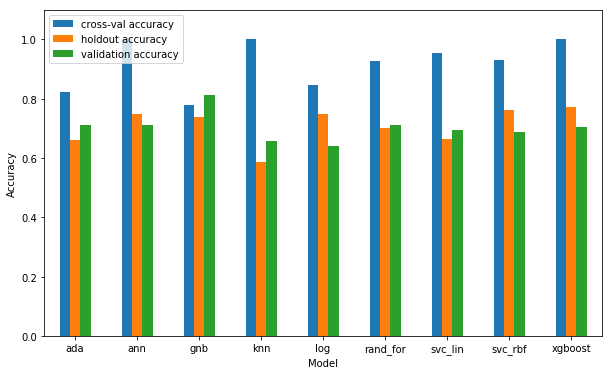

In [23]:
import matplotlib.pyplot as plt
d = getData().groupby('model').first()

%matplotlib inline
ax = d.drop(['cv'], axis=1).plot(kind='bar', figsize=(10,6), rot=0)
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_ybound((0,1.1))
l = ax.legend(labels=['cross-val accuracy','holdout accuracy', 'validation accuracy'])
fig = ax.get_figure()
fig.savefig('images/optimization_accuracy.png')


plt.show()

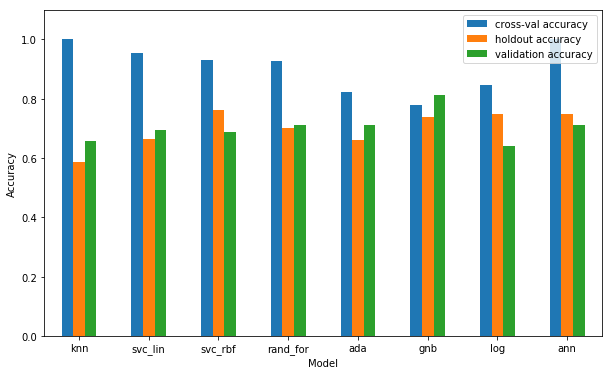

In [30]:
import matplotlib.pyplot as plt
d = getData().groupby('model').first().loc[['knn','svc_lin', 'svc_rbf', 'rand_for', 'ada', 'gnb', 'log', 'ann']]

%matplotlib inline
ax = d.drop(['cv'], axis=1).plot(kind='bar', figsize=(10,6), rot=0)
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_ybound((0,1.1))
l = ax.legend(labels=['cross-val accuracy','holdout accuracy', 'validation accuracy'])
fig = ax.get_figure()
fig.savefig('images/optimization_accuracy.png')


plt.show()